# Homework 7 for Perspective
## Qian Zhang

In [1]:
# Import packages 

import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import statsmodels.api as sm

import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
from sklearn import metrics 
from sklearn.metrics import classification_report, mean_squared_error
from pylab import rcParams
from scipy.interpolate import LSQUnivariateSpline

import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style('whitegrid')

## Question 1

In [2]:
# load in the data

df=pd.read_csv('data/strongdrink.txt')

df.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
# test na values

df.isna().sum()

cultivar      0
alco          0
malic         0
ash           0
alk           0
magn          0
tot_phen      0
flav          0
nonfl_phen    0
proanth       0
color_int     0
hue           0
OD280rat      0
proline       0
dtype: int64

### (a)

In [4]:
# split the data

y=df["cultivar"]
X=df[["alco","malic","tot_phen","color_int"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,random_state=20)

In [5]:
# estimation

mlog=LogisticRegression(solver='lbfgs',multi_class='multinomial').fit(X_train, y_train)

# report the coe

pd.DataFrame({"j=1":np.append(mlog.intercept_[0],mlog.coef_[0]),
              "j=2":np.append(mlog.intercept_[1],mlog.coef_[1])},
               index=["$b_0$(intercept)","$b_1$(alco)",'$b_2$(malic)','$b_3$(tot_phen)','$b_4$(color_int)'])

,j=1,j=2
$b_0$(intercept),-24.027617,22.780733
$b_1$(alco),1.701734,-1.466297
$b_2$(malic),-0.265788,-0.332951
$b_3$(tot_phen),1.224101,0.663556
$b_4$(color_int),0.022507,-0.922682


In [6]:
# count the obs

print ('The observation numbers of cultivar when j=1,2,3 are \n\n{},{},and {}.'.format(np.sum(y==1),np.sum(y==2),np.sum(y==3)))

print ('\nThe observation numbers of cultivar in the training set when j=1,2,3 are \n\n{},{},and {}.'.format(np.sum(y_train==1),np.sum(y_train==2),np.sum(y_train==3)))

# calc the error rates

y_pred=mlog.predict(X_test)
print('\n',classification_report(y_test, y_pred))

The observation numbers of cultivar when j=1,2,3 are 

59,71,and 46.

The observation numbers of cultivar in the training set when j=1,2,3 are 

46,50,and 36.

               precision    recall  f1-score   support

           1       0.87      1.00      0.93        13
           2       1.00      0.90      0.95        21
           3       1.00      1.00      1.00        10

    accuracy                           0.95        44
   macro avg       0.96      0.97      0.96        44
weighted avg       0.96      0.95      0.96        44



From the report, the error rate is <strong>13%, 0% and 0%</strong> respectively when $j = 1,2,3$.

Also, while $j=2$ and $j=3$ have the same error rate, $j = 3$ has the highest f1 score, so we can say that the model predicts $j = 3$ best.

From the counts of observations above, we know that the one with the most observations is $j=2$. Therefore, the most accurately predicted category is <strong>NOT</strong> the one with the most observations, and $j=3$ has the least number of observations.

In [7]:
# report the MSE

mse_a = np.mean((y_test - y_pred) ** 2)
print("The mean squared error for test data is {}.".format(mse_a))

The mean squared error for test data is 0.045454545454545456.


### (b)

In [8]:
# perform a LOOCV 

Xvars = df[["alco","malic","tot_phen","color_int"]].values
yvars = df['cultivar'].values
N_loo = Xvars.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(Xvars)
MSE_vec = np.zeros(N_loo)

y_test2 = np.zeros(N_loo)
y_pred2 = np.zeros(N_loo)

for train_index, test_index in loo.split(Xvars):
    
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvars[train_index], yvars[test_index]
    
    y_test2[test_index] = y_test
    
    LogReg = LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter=1000)
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    
    y_pred2[test_index] = y_pred

    MSE_vec[test_index] = (1-(y_test == y_pred))
    #print('MSE for test set', test_index, ' is', MSE_vec[test_index])

# report the MSE

MSE_loo = MSE_vec.mean()
MSE_loo_std = MSE_vec.std()
print('Loocv test estimate MSE =', MSE_loo,
      ',\nLoocv test loocv estimate MSE standard err=', MSE_loo_std)

Loocv test estimate MSE = 0.07954545454545454 ,
Loocv test loocv estimate MSE standard err= 0.2705882022679695


In [9]:
# calc the error rate

print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

         1.0       0.90      0.93      0.92        59
         2.0       0.91      0.90      0.91        71
         3.0       0.96      0.93      0.95        46

    accuracy                           0.92       176
   macro avg       0.92      0.92      0.92       176
weighted avg       0.92      0.92      0.92       176



From the report, the error rate is <strong>10%, 9% and 4%</strong> respectively in $j=1,2,3$. The error rate in $j=1$ decreases but it increases in $j=2$ and $j=3$ compared with the error rates in (a).

### (c)

In [10]:
k = 4
kf = KFold(n_splits=k, random_state=10, shuffle=True)
kf.get_n_splits(Xvars)

MSE_vec_kf = np.zeros(k)

y_testk = np.zeros(N_loo)
y_predk = np.zeros(N_loo)

k_ind = int(0)

for train_index, test_index in kf.split(Xvars):

    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvars[train_index], yvars[test_index]
    
    y_testk[test_index] = y_test

    LogReg = LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter=1000)
    
    LogReg.fit(X_train, y_train)
    
    y_pred = LogReg.predict(X_test)
    
    y_predk[test_index] = y_pred
    
    MSE_vec_kf[k_ind] = (1-(y_test == y_pred)).mean()
    
    #print('k-fold estimate MSE for test set', k_ind, ' is', MSE_vec_kf[k_ind])

    k_ind += 1

#report MSE

MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()
print('\nTest k-fold estimate MSE (k=4)=', MSE_kf,
      '\nTest k-fold estimate MSE standard err=', MSE_kf_std)


Test k-fold estimate MSE (k=4)= 0.09090909090909091 
Test k-fold estimate MSE standard err= 0.04821182598999188


In [11]:
# calc the error rate

print(classification_report(y_testk, y_predk))

              precision    recall  f1-score   support

         1.0       0.87      0.93      0.90        59
         2.0       0.91      0.87      0.89        71
         3.0       0.96      0.93      0.95        46

    accuracy                           0.91       176
   macro avg       0.91      0.91      0.91       176
weighted avg       0.91      0.91      0.91       176



From the report, the error rate is <strong>13%, 9% and 4%</strong> respectively in $j=1,2,3$. 

Compared with (a), the error rate in $j=1$ remains the same, but the error rates for $j=2$ and $j=3$ are higher.

Compared with (b), the error rates for $j=2$ and $j=3$ remain the same, but the error rate for $j=1$ is higher.

## Question 2

In [12]:
# load the data

df2=pd.read_csv("data/CoolIndex.txt",names=["age","cool_index"])
df2.head()

,age,cool_index
0,11.0,10.981602
1,11.0,11.364925
2,11.0,10.190227
3,11.0,9.903725
4,11.0,8.997918


### (a)

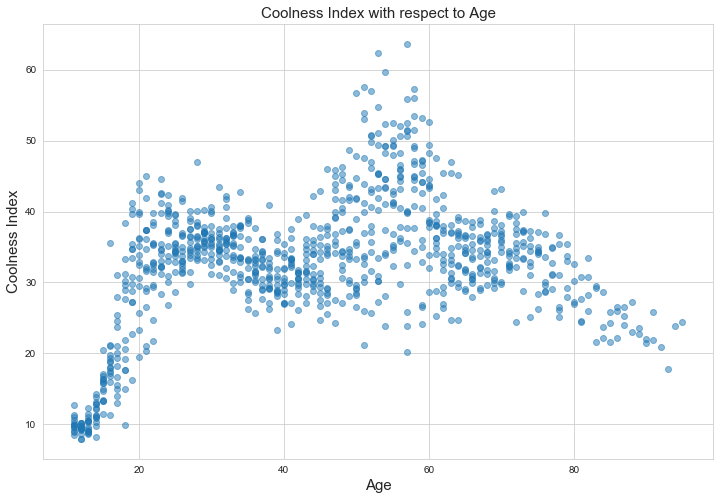

In [13]:
# draw the plot

plt.figure(figsize=(12,8))

plt.scatter(df2['age'],df2['cool_index'],alpha=0.5)
plt.xlabel("Age",size=15)
plt.ylabel("Coolness Index",size=15)
plt.title("Coolness Index with respect to Age",size=15)
plt.show()

### (b)

In [14]:
# create age group

df2["age1"]=np.where((df2.age>=11) & (df2.age<22),1,0)
df2["age2"]=np.where((df2.age>=22) & (df2.age<40),1,0)
df2["age3"]=np.where((df2.age>=40) & (df2.age<59),1,0)
df2["age4"]=np.where((df2.age>=59) & (df2.age<77),1,0)
df2["age5"]=np.where((df2.age>=77) & (df2.age<=95),1,0)

In [15]:
# run the ols

X_q2=df2[['age1','age2','age3','age4','age5']]
reg_ols=sm.OLS(df2['cool_index'],X_q2).fit()
print(reg_ols.summary())

                            OLS Regression Results                            
Dep. Variable:             cool_index   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Wed, 26 Feb 2020   Prob (F-statistic):          3.73e-114
Time:                        02:57:02   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age1          20.1025      0.562     35.746      0.0

In [16]:
# report the estimation

print('Estimated Stepwise function values are:\n')

print(reg_ols.params)

Estimated Stepwise function values are:

age1    20.102457
age2    34.475788
age3    37.635105
age4    35.225400
age5    27.296378
dtype: float64


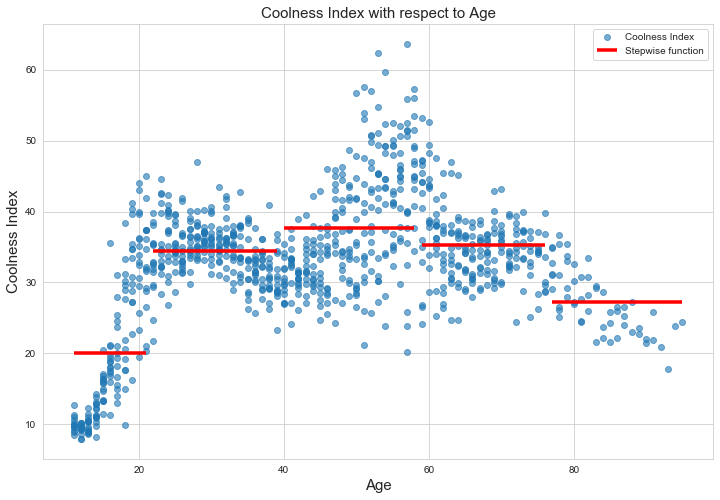

In [17]:
#plot the values

plt.figure(figsize=(12,8))

plt.scatter(df2['age'],df2['cool_index'], alpha=0.6,label='Coolness Index')

values = reg_ols.params

# set the range

x_min = np.array([11, 22, 40, 59, 77])
x_max = np.array([21, 39, 58, 76, 95])

plt.hlines(values, x_min, x_max, color='red', label='Stepwise function',linewidth=3.5)

plt.xlabel("Age",size=15)
plt.ylabel("Coolness Index",size=15)
plt.legend()

plt.title("Coolness Index with respect to Age",size=15)
plt.show()

In [18]:
# predict the 73 year old man

print('Predicted coolness index of a 73-year old individual from the stepwise function is {}.'.format(reg_ols.predict([0,0,0,1,0])[0]))

Predicted coolness index of a 73-year old individual from the stepwise function is 35.22540004024275.


### (c)

In [19]:
# fit the linear spline

t = np.array([22,40,59,77])

df2.sort_index(0, ascending=True, inplace=True)

group_age = df2.groupby('age', as_index = False).mean()

reg_linear = LSQUnivariateSpline(group_age.age.values, group_age.cool_index.values, t, k=1)

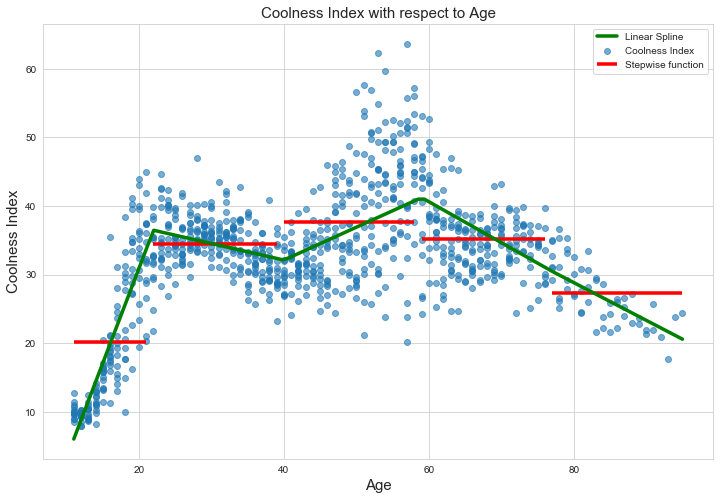

In [20]:
# plot

plt.figure(figsize=(12,8))

plt.scatter(df2['age'],df2['cool_index'], alpha=0.6,label='Coolness Index')

values = reg_ols.params

x_min = np.array([11, 22, 40, 59, 77])
x_max = np.array([21, 39, 58, 76, 95])

age_pt=np.linspace(11,95,100)

plt.hlines(values, x_min, x_max, color='red', label='Stepwise function',linewidth=3.5)

plt.plot(age_pt, reg_linear(age_pt), color='green', label='Linear Spline',linewidth=3.5)

plt.xlabel("Age",size=15)
plt.ylabel("Coolness Index",size=15)
plt.legend()

plt.title("Coolness Index with respect to Age",size=15)
plt.show()

In [21]:
# predict the 73 year old man

print('Predicted coolness index of a 73-year-old individual from linear spline is {}.'.format(reg_linear(73)))

Predicted coolness index of a 73-year-old individual from linear spline is 32.86784862349653.


### (d)

In [22]:
# fit the cubic spline

t = np.array([22,40,59,77])

df2.sort_index(0, ascending=True, inplace=True)

group_age = df2.groupby('age', as_index = False).mean()

reg_cubic = LSQUnivariateSpline(group_age.age.values, group_age.cool_index.values, t, k=3)

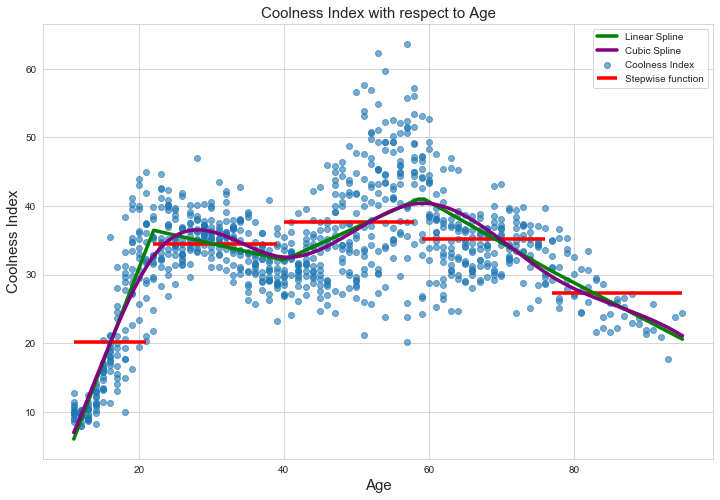

In [23]:
# plot 

plt.figure(figsize=(12,8))

plt.scatter(df2['age'],df2['cool_index'], alpha=0.6,label='Coolness Index')

values = reg_ols.params

x_min = np.array([11, 22, 40, 59, 77])
x_max = np.array([21, 39, 58, 76, 95])

age_pt=np.linspace(11,95,100)

plt.hlines(values, x_min, x_max, color='red', label='Stepwise function',linewidth=3.5)

plt.plot(age_pt, reg_linear(age_pt), color='green', label='Linear Spline',linewidth=3.5)

plt.plot(age_pt, reg_cubic(age_pt), color='purple', label='Cubic Spline',linewidth=3.5)

plt.xlabel("Age",size=15)
plt.ylabel("Coolness Index",size=15)
plt.legend()

plt.title("Coolness Index with respect to Age",size=15)
plt.show()

In [24]:
# predict the 73 year old man

print('Predicted coolness index of a 73-year-old individual from cubic spline is {}.'.format(reg_cubic(73)))

Predicted coolness index of a 73-year-old individual from cubic spline is 32.642301066279764.
